In [1]:
from mpl_toolkits.mplot3d import Axes3D         # Cargo Axes3D de mpl_toolkits.mplot3d
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import pandas as pd
from matplotlib import animation
import sys 
import math
%matplotlib inline

In [2]:
#Libreria para programar en parallelo
from pyspark import SparkContext
import multiprocessing as mp
from joblib import Parallel, delayed

# Forma 1

Paralelizamos el código haciendo que DDD y RRR se lleve a cabo en dos hilos al igual que DDR y DRR.

In [3]:
#FUNCIÓN DE PARA HACER HISTOGRAMAS 
def Histos_XXX(p,bn,point_max):
    """ 
    Función para construir los histogramas 
    
    p = datos
    bn = tamaño de bins
    point_max = punto máximo en el histograma
    
    """
    
    #Inicializamos los arreglos de los histogramas
    NDDD = np.zeros((bn,bn,bn))
    
    # =========================================================================================== 
    
    n = 0
    for (ii) in zip(p):
        n = n+1
        
        s = ii-p[n:] # Diferencia entre el punto pivote y los demas puntos siguientes 
        r = np.sqrt(s[:,0]**2+s[:,1]**2+s[:,2]**2)
        
        m = 0
        for (kk) in zip(p[n:]):
            
            #DDD ===============================================================================
            r12 = np.ones_like(r[m+1:])*r[m]
            r13 = r[m+1:]
        
            ss = kk-p[n:][m+1:] # Diferencia entre el punto pivote y los demas puntos siguientes 
            r32 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
        
            # Histogramas para DDD
            dis, dim = np.histogramdd(np.array([r12,r13,r32]).T,bins = [bn,bn,bn], 
                                    range=[[0,point_max],[0,point_max],[0,point_max]])
            NDDD = NDDD + dis
            
            m = m+1
    return NDDD

In [4]:
#FUNCIÓN DE PARA HACER HISTOGRAMAS 
def Histos_XXY(datos,bn,point_max):
    
    p = datos[0]
    p_r = datos[1]
    
    """ 
    Función para construir los histogramas 
    
    p = datos
    p_r = random
    bn = tamaño de bins
    point_max = punto máximo en el histograma
    
    """
    
    #Inicializamos los arreglos de los histogramas
    NDDR = np.zeros((bn,bn,bn))
    
    # =========================================================================================== 
    
    n = 0
    for (ii, jj) in zip(p, p_r):
        n = n+1
        
        s = ii-p[n:] # Diferencia entre el punto pivote y los demas puntos siguientes 
        r = np.sqrt(s[:,0]**2+s[:,1]**2+s[:,2]**2)
        
        m = 0
        for (kk, ll) in zip(p[n:], p_r[n:]):
            
            #DDR ===============================================================================
            r12 = np.ones_like(p_r.T[0])*r[m]
            
            ss = ii-p_r # Diferencia entre el punto pivote y el punto en la muestra random 
            r13 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
            
            ss = kk-p_r # Diferencia entre el punto 2 de los datos y el punto en la muestra random 
            r32 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
            
            # Histogramas para DDR
            dis, dim = np.histogramdd(np.array([r12,r13,r32]).T,bins = [bn,bn,bn], 
                                    range=[[0,point_max],[0,point_max],[0,point_max]])
            NDDR = NDDR + dis
            
            m = m+1
    
    return  NDDR

In [18]:
data = np.loadtxt('/home/echeveste/mis_trabajos/correlation_f_2/datos/dat_glx/data_500.dat')[:,:3]
rand = np.loadtxt('/home/echeveste/mis_trabajos/correlation_f_2/datos/dat_glx/rand0_500.dat')[:,:3]

In [10]:
sc.stop()

In [11]:
#Escogemos el número de nucleos con los que trabajaremos 
nuc = 2
sc = SparkContext(master='local[{0}]'.format(int(nuc)))
print(sc.master)

local[2]


In [12]:
#Juntamos los datos y randoms en un arreglo 
data_rand = sc.parallelize(np.split(np.concatenate((data, rand)),2))

In [9]:
#No paralelizado
#Hacemos los histogramas DDD y RRR
start = time.perf_counter()

DDD = Histos_XXX(data,30,180)
RRR = Histos_XXX(rand,30,180)

finish = time.perf_counter()

print(f'Finializó en {round(finish-start,2)} segundos\n')

Finializó en 70.29 segundos



In [10]:
#Paralelizado
#Hacemos los histogramas DDD y RRR
start_pll = time.perf_counter()

XXX = data_rand.map(lambda x: Histos_XXX(x,30,180)).collect()

finish_pll = time.perf_counter()
sc.stop()
print(f'Finializó en {round(finish_pll-start_pll,2)} segundos\n')

Finializó en 47.22 segundos



In [11]:
DDD = XXX[0]
RRR = XXX[1]

In [12]:
print(f'Paralelizado fue {round((finish-start)/(finish_pll-start_pll),2)} veces mas rapido\n')

Paralelizado fue 1.49 veces mas rapido



In [29]:
#Paralelizado
start_pll = time.perf_counter()

XXY = Parallel(n_jobs=nuc)(delayed(Histos_XXY)(ii,30,180) for ii in [[data,rand],[rand,data]])

finish_pll = time.perf_counter()
print(f'Finializó en {round(finish_pll-start_pll,2)} segundos\n')

Finializó en 42.48 segundos



In [32]:
DDR = XXY[0]
DRR = XXY[1]

# Forma 2

De esta forma tenemos la libertad de agregar mas nucleos si los tuvieramos. Por ahora solo usaremos 2 de los cuatro

In [13]:
def puntos_23(ii,p,NDDD,bn,point_max):
    
    s = ii-p 
    r = np.sqrt(s[:,0]**2+s[:,1]**2+s[:,2]**2)
        
    m = 0
    for (kk) in zip(p):
            
        r12 = np.ones_like(r[m+1:])*r[m]
        r13 = r[m+1:]
    
        ss = kk-p[m+1:]
        r32 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
        
        dis, dim = np.histogramdd(np.array([r12,r13,r32]).T,bins = [bn,bn,bn], 
                                  range=[[0,point_max],[0,point_max],[0,point_max]])
        NDDD = NDDD + dis
        
        m = m+1
    
    return NDDD

In [14]:
#FUNCIÓN DE PARA HACER HISTOGRAMAS 
def Histos_XXX(p,bn,point_max,nuc):

    #Inicializamos el arreglo del histograma
    NDDD = np.zeros((bn,bn,bn))
    
    return np.sum(np.array(Parallel(n_jobs=nuc)(delayed(puntos_23)(p[i],p[i+1:],NDDD,bn,point_max) for i in range(len(p)))),axis=0)
    
    

In [15]:
def puntos(ii,p,p_r,NDDR,bn,point_max,n):
    
    n = n+1
        
    s = ii-p[n:] # Diferencia entre el punto pivote y los demas puntos siguientes 
    r = np.sqrt(s[:,0]**2+s[:,1]**2+s[:,2]**2)
        
    m = 0
    for kk in p[n:]:
            
        #DDR ===============================================================================
        r12 = np.ones_like(p_r.T[0])*r[m]
        
        ss = ii-p_r # Diferencia entre el punto pivote y el punto en la muestra random 
        r13 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
        
        ss = kk-p_r # Diferencia entre el punto 2 de los datos y el punto en la muestra random 
        r32 = np.sqrt(ss[:,0]**2+ss[:,1]**2+ss[:,2]**2)
        
        # Histogramas para DDR
        dis, dim = np.histogramdd(np.array([r12,r13,r32]).T,bins = [bn,bn,bn], 
                                range=[[0,point_max],[0,point_max],[0,point_max]])
        NDDR = NDDR + dis
            
        m = m+1
    return  NDDR

In [16]:
#FUNCIÓN DE PARA HACER HISTOGRAMAS 
def Histos_XXY(p,p_r,bn,point_max,nuc):
    
    #Inicializamos los arreglos de los histogramas
    NDDR = np.zeros((bn,bn,bn))
    
    # =========================================================================================== 
    
    return np.sum(np.array(Parallel(n_jobs=nuc)(delayed(puntos)(p[i],p,
                                                         p_r,NDDR,bn,point_max,i) for i in range(len(p)))),axis=0)

In [19]:
#Paralelizado

nuc = 2
bins = 30

start_pll = time.perf_counter()

DDD_2 = Histos_XXX(data,bins,180,nuc)
RRR_2 = Histos_XXX(rand,bins,180,nuc)

DDR_2 = Histos_XXY(data,rand,bins,180,nuc)
DRR_2 = Histos_XXY(rand,data,bins,180,nuc)

finish_pll = time.perf_counter()
print(f'Finializó en {round(finish_pll-start_pll,2)} segundos\n')

Finializó en 86.5 segundos



Como vemos, el tiempo en el que se realizan los histograms es practicamente el mismo que en la primera forma de paralelizar. Por lo tanto, esta forma es mejor por la capasidad de agregar más núcleos para mayor eficiencia.

In [20]:
DDD = DDD_2
RRR = RRR_2
DDR = DDR_2
DRR = DRR_2

for i in range(bins - 2):
    for j in range(i+1, bins-1):
        for k in range(j+1, bins):
            s = DDD_2[i][j][k] + DDD_2[i][k][j] + DDD_2[j][i][k] + DDD_2[j][k][i] + DDD_2[k][i][j] + DDD_2[k][j][i]
            DDD[i][j][k] = s
            DDD[i][k][j] = s
            DDD[j][i][k] = s
            DDD[j][k][i] = s
            DDD[k][i][j] = s
            DDD[k][j][i] = s
            s = RRR_2[i][j][k] + RRR_2[i][k][j] + RRR_2[j][i][k] + RRR_2[j][k][i] + RRR_2[k][i][j] + RRR_2[k][j][i]
            RRR[i][j][k] = s
            RRR[i][k][j] = s
            RRR[j][i][k] = s
            RRR[j][k][i] = s
            RRR[k][i][j] = s
            RRR[k][j][i] = s
            
for i in range(bins - 2):
    for j in range(i+1, bins-1):
        for k in range(j+1,bins):
            s = DDR_2[i][j][k] + DDR_2[j][i][k]+ DDR_2[i][k][j]+ DDR_2[j][k][i]+ DDR_2[k][i][j] + DDR_2[k][j][i]
            DDR[i][j][k] = s
            DDR[i][k][j] = s
            DDR[j][i][k] = s
            DDR[j][k][i] = s
            DDR[k][i][j] = s
            DDR[k][j][i] = s
        
            s = DRR_2[i][j][k] + DRR_2[j][i][k]+ DRR_2[i][k][j]+ DRR_2[j][k][i]+ DRR_2[k][i][j]+ DRR_2[k][j][i]
            DRR[i][j][k] = s
            DRR[i][k][j] = s
            DRR[j][i][k] = s
            DRR[j][k][i] = s
            DRR[k][i][j] = s
            DRR[k][j][i] = s

In [28]:
#Función de correlación Landy-Szalay
def estima_ss(NDDD, NRRR, NDDR, NDRR):
    return (NDDD - 3*NDDR + 3*NDRR - NRRR)/NRRR

In [29]:
estim_ss = estima_ss(DDD, RRR, DDR, DRR)

<ipython-input-28-c70e7b1a3d8f>:3: RuntimeWarning: divide by zero encountered in true_divide
  return (NDDD - 3*NDDR + 3*NDRR - NRRR)/NRRR
<ipython-input-28-c70e7b1a3d8f>:3: RuntimeWarning: invalid value encountered in true_divide
  return (NDDD - 3*NDDR + 3*NDRR - NRRR)/NRRR


In [30]:
estim_ss[np.where(np.isnan(estim_ss))] = 0
estim_ss[np.where(np.isinf(estim_ss))] = 0

In [31]:
def imag(x,y,t,cmap,limt):
    
    plt.figure(figsize=(6,6), dpi=100)
    plt.imshow(x,origin='lower',cmap=cmap, interpolation= 'bilinear', extent=[0,180,0,180], vmin=-limt, vmax=limt)
    cax=plt.colorbar()
    plt.contour(x,10,cmap=plt.cm.gray,linewidths=1
                ,extent=[0,180,0,180],vmin=-limt, vmax=limt)
    plt.ylabel('$r_1$',fontsize = 16)
    plt.xlabel('$r_2$',fontsize = 16)
    plt.title(y,fontsize = 16)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax.set_label(t,labelpad = 15,fontsize = 15)
    line_colour1 = ('royalblue', 'blue', 'mediumblue', 'darkblue')
    plt.plot()

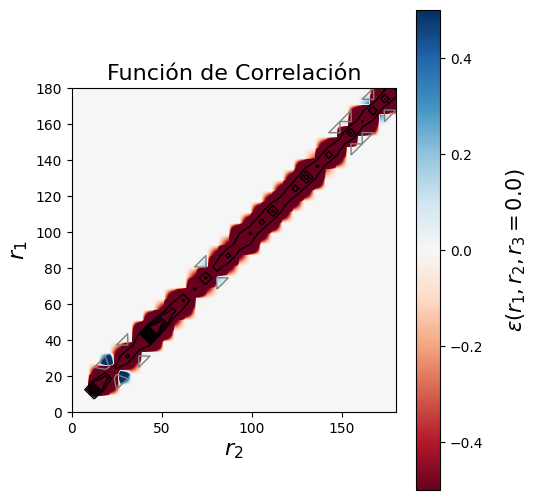

In [35]:
limt = 0.5
r = 0
imag(estim_ss[r],'Función de Correlación','$\epsilon(r_1,r_2,r_3={0})$'.format(r*(180)/30),cmap='RdBu', limt = limt)